# 9.7 序列到序列学习(seq2seq)

本节中，将使用两个循环神经网络的编码器和解码器，应用于seq2seq的学习任务

运行方式解释：
- 输入序列的信息被编码到循环神经网络编码器的隐状态中
- 为了连续生成输出序列的词元，独立的循环神经网络解码器是基于输入序列的编码信息

在循环神经网络解码器的初始化时间步，有两个特点的设计：
- 特定的'\<bos\>'表示序列开始词元，它是解码器的输入序列的第一个词元
- 使用循环神经网络编码器最终的隐状态来初始化解码器的隐状态

In [1]:
import collections
import math
import torch
from torch import nn
from d2l import torch as d2l

## 9.7.1 编码器

功能：将长度可变的输入序列转换成形状固定的上下文变量$c$，并且将输入序列的信息在该上下文变量中进行编码，可以使用循环神经网络来设计编码器

记住：编码器中展开的LSTMs创造的Context Vector $c$ 将用于初始化解码器中的LSTMs

使用词嵌入来使得输入序列能被放入神经网络编码器中

对于嵌入层(embedding layer)来说，其行数为：输入词表的大小(vocab_size)；其列数为：特征向量的维度(embed_size)。对于任意输入词元的索引i，嵌入层获取权重矩阵的第i行以返回其特征向量

In [2]:
#@save
class Seq2SeqEncoder(d2l.Encoder):
    '''用于序列到序列学习的循环神经网络'''
    def __init__(self,vocab_size,embed_size,num_hiddens,num_layers,
                 dropout=0,**kwargs):
        super(Seq2SeqEncoder,self).__init__(**kwargs)
        # 嵌入层
        self.embedding = nn.Embedding(vocab_size,embed_size)
        self.rnn = nn.GRU(embed_size,num_hiddens,num_layers,
                          dropout=dropout)

    def forward(self,X,*args):
        # 输出“X”的形状为(batch_size,num_steps,embed_size)
        X = self.embedding(X)
        # 在循环神经网络模型中，第一个轴对应于时间步
        X = X.permute(1,0,2)
        # 如果未提及状态，则默认为0
        output,state = self.rnn(X)
        # output的形状为(num_steps,batch_size,num_hiddens)
        # state[0]的形状为(num_layers,batch_size,num_hiddens)
        return output,state

以下是实例化部分：
- 两层门控循环单元编码器
- 隐藏单元数为16
- 输入序列X(批量大小为4，时间步为7)
- 输出output张量形状为(时间步数，批量大小，隐藏单元数)

In [3]:
encoder = Seq2SeqEncoder(vocab_size=10,embed_size=8,num_hiddens=16,
                         num_layers=2)
encoder.eval()
X = torch.zeros((4,7),dtype=torch.long)
output,state = encoder(X)
output.shape

torch.Size([7, 4, 16])

上述代码使用的是门控循环单元，在最后一个时间步的多层隐状态的形状是(隐藏层数，批量大小，隐藏单元数)

也可以用LSTMs，此时state中还将包含记忆元信息

In [4]:
state.shape

torch.Size([2, 4, 16])

## 9.7.2 解码器

使用另一个循环神经网络作为解码器，获得解码器的隐状态，使用全连接输出层和softmax操作来计算在时间步t输出$y_t$的条件概率分布

In [5]:
class Seq2SeqDecoder(d2l.Decoder):
    '''用于序列到序列学习的循环神经网络解码器'''
    def __init__(self,vocab_size,embed_size,num_hiddens,num_layers,
                 dropout=0,**kwargs):
        super(Seq2SeqDecoder,self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size,embed_size)
        self.rnn = nn.GRU(embed_size+num_hiddens,num_hiddens,num_layers,
                          dropout=dropout)
        self.dense = nn.Linear(num_hiddens,vocab_size)

    def init_state(self,enc_outputs,*args):
        return enc_outputs[1]

    def forward(self,X,state):
        # 输出‘X’的形状为(batch_size,num_steps,embed_size)
        X = self.embedding(X).permute(1,0,2)
        # 广播context，使其具有与X相同的num_steps
        context = state[-1].repeat(X.shape[0],1,1)
        X_and_context = torch.cat((X,context),2)
        output,state = self.rnn(X_and_context,state)
        output = self.dense(output).permute(1,0,2)
        # output的形状为(batch_size,num_steps,vocab_size)
        # state[0]的形状为(num_layers,batch_size,num_hiddens)
        return output,state

In [6]:
decoder = Seq2SeqDecoder(vocab_size=10,embed_size=8,num_hiddens=16,
                         num_layers=2)
decoder.eval()
state = decoder.init_state(encoder(X))
output,state = decoder(X,state)
output.shape,state.shape

(torch.Size([4, 7, 10]), torch.Size([2, 4, 16]))

## 9.7.3 损失函数

在每个时间步，解码器预测了输出词元的概率分布。类似于语言模型，可以使用softmax来获得分布，并通过计算交叉熵损失函数来进行优化

在9.5节中，我们将特定的填充词元加入到序列的末尾，使得不同长度的序列可以以相同形状的小批量加载。但是在损失函数的计算中，我们应该剔除填充词元的预测

下面的sequence_mask函数通过零值化屏蔽不相关的项，以便于后面任何不相关预测的计算都是与零的乘积

In [7]:
#@save
def sequence_mask(X,valid_len,value=0):
    """在任务序列中屏蔽不相关的项"""
    maxlen = X.shape[1]
    mask = torch.arange((maxlen),dtype=torch.float32,
                         device=X.device)[None,:] < valid_len[:,None]
    X[~mask]=value
    return X

# 例如，如果两个序列的有效长度（不包括填充词元）分别为1和2，则第一个序列的第一项和第二个序列的前两项之后的剩余项将被清零
X = torch.tensor([[1,2,3],[4,5,6]])
sequence_mask(X,torch.tensor([1,2]))

tensor([[1, 0, 0],
        [4, 5, 0]])

In [8]:
X = torch.ones(2,3,4)
# 第一个样本有效长度是1，第二个样本有效长度是2
sequence_mask(X,torch.tensor([1,2]),value=-1)

tensor([[[ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.]],

        [[ 1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.]]])

现在就可以通过扩展softmax交叉熵损失函数来屏蔽不相关的预测

In [9]:
#@save
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """带屏蔽的softmax交叉熵损失函数"""
    # pred的形状为(batch_size,num_steps,vocab_size)，含义为每个时间步的预测概率分布（语言模型中预测下一个词的概率）
    # label的形状为(batch_size,num_steps)，含义为每个时间步的真实词索引（真实的下一个词在词汇表中的位置）
    # valid_len的形状为(batch_size,)，含义为每个样本的有效序列长度
    def forward(self,pred,label,valid_len):
        weights = torch.ones_like(label)  # 形状为(batch_size,num_steps)
        weights = sequence_mask(weights,valid_len)
        self.reduction = 'none' # 禁用默认的损失聚合（如均值或求和）
        # unweighted_loss形状为（batch_size,num_steps）
        # pred.permute(0,2,1)：将预测值调整为(batch_size,num_steps,vocab_size)，以满足PyTorch交叉熵损失函数的输入要求（通道位数第二维）
        unweighted_loss = super(MaskedSoftmaxCELoss,self).forward(
            pred.permute(0,2,1),label
        )
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        return weighted_loss

对上述代码中permute()函数的解释：

- 功能：重新排列张量的维度顺序（不改变数据内容，仅调整维度索引）
- 输入参数：维度索引的新顺序
- 示例：假设原张量形状为(batch_size,num_steps,vocab_size)，即维度索引为(0,1,2):

In [10]:
pred_test = torch.randn(2,3,4) # 形状：(batch_size=2,num_steps=3,vocab_size=4)
pred_permuted_test = pred_test.permute(0,2,1) # 新形状：(2,4,3)

# 原维度索引：0(batch维度)，1(时间步维度)，2(词表维度)
# 调整后维度索引：0(batch维度)，2(词表维度)，1(时间步维度)

调整的原因：

PyTorch的交叉熵损失函数nn.CrossEntropyLoss要求输入的预测值(logits)形状为：(batch_size,num_class,dim1,dim2,...)
- 关键规则：类别维度(num_class,即词表大小)必须放在第二维(维度索引1)
- 标签形状：(batch_size,dim1,dim2,...)与预测值的后几个维度对齐

在序列任务中：
- 预测值pred的原始形状:(batch_size, num_steps, vocab_size)
    - num_steps是时间步维度，vocab_size是类别维度
- 调整后的形状:(batch_size, vocab_size, num_steps)
    - 将类别维度（vocab_size）移动到第二维，以符合 CrossEntropyLoss 的要求

In [11]:
loss = MaskedSoftmaxCELoss()
loss(torch.ones(3,4,10),torch.ones((3,4),dtype=torch.long),
     torch.tensor([4,2,0]))

tensor([2.3026, 1.1513, 0.0000])

## 9.7.4 训练

在训练过程中，特定序列的开始词元('\<bos\>')和原始的输出序列（不包序列结束词元）连接在一起作为解码器的输入。这是*强制教学*(teacher forcing)，因为原始的输出序列(词元的标签)被送入解码器，或者将来自上一个时间步的预测得到的词元作为解码器的当前输入

In [12]:
#@save
def train_seq2seq(net,data_iter,lr,num_epochs,tgt_vocab,device):
    """训练序列到序列模型"""
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])
    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(),lr=lr)
    loss = MaskedSoftmaxCELoss()
    net.train()
    animator = d2l.Animator(xlabel='epoch',ylabel='loss',
                            xlim=[10,num_epochs])
    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2) # 训练损失和，词元数量
        for batch in data_iter:
            optimizer.zero_grad()
            X,X_valid_len,Y,Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                               device=device).reshape(-1,1)
            dec_input = torch.cat([bos,Y[:,:-1]],1) # 强制教学
            Y_hat,_ = net(X,dec_input,X_valid_len)
            l = loss(Y_hat,Y,Y_valid_len)
            l.sum().backward() # 损失函数的标量进行反向传播
            d2l.grad_clipping(net,1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(),num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch+1,(metric[0]/metric[1],))
    print(f'loss{metric[0]/metric[1]:.3f},{metric[1]/timer.stop():.1f} '
          f'tokens/sec on {str(device)}')

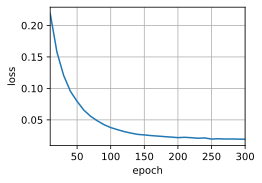

In [13]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 300, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers,
                        dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers,
                        dropout)
net = d2l.EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

## 9.7.5 预测

为了采用一个接着一个词元的方式预测输出序列，每个解码器当前时间步的输入都将来自前一个时间步的预测词元

In [14]:
#@save
def predict_seq2seq(net,src_sentence,src_vocab,tgt_vocab,num_steps,
                    device,save_attention_weights=False):
    """序列到序列模型的预测"""
    net.eval()
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [src_vocab['<eos>']]
    enc_valid_len = torch.tensor([len(src_tokens)],device=device)
    src_tokens = d2l.truncate_pad(src_tokens,num_steps,src_vocab['<pad>'])
    # 添加批量轴
    enc_X = torch.unsqueeze(
        torch.tensor(src_tokens,dtype=torch.long,device=device),dim=0
    )
    enc_outputs = net.encoder(enc_X,enc_valid_len)
    dec_state = net.decoder.init_state(enc_outputs,enc_valid_len)
    # 添加批量轴
    dec_X = torch.unsqueeze(torch.tensor(
        [tgt_vocab['<bos>']],dtype=torch.long,device=device),dim=0
    )
    output_seq,attention_weight_seq = [],[]
    for _ in range(num_steps):
        Y,dec_state = net.decoder(dec_X,dec_state)
        # 我们使用预测可能性最大的词元，作为解码器在下一个时间步的输入
        dec_X = Y.argmax(dim=2)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        # 保存注意力权重（稍后讨论）
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        # 一旦序列结束词元被预测，输出序列的生成就完成了
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq)),attention_weight_seq

## 9.7.6 预测序列的评估

使用BLEU进行评估，该方法现在已经被广泛用于度量许多应用的输出序列的质量，具体内容见课本

In [15]:
def bleu(pred_seq,label_seq,k): #@save
    """计算BLEU"""
    pred_tokens,label_tokens = pred_seq.split(' '),label_seq.split(' ')
    len_pred,len_label = len(pred_tokens),len(label_tokens)
    score = math.exp(min(0,1-len_label/len_pred))
    for n in range(1,k+1):
        num_matches,label_subs = 0,collections.defaultdict(int)
        for i in range(len_label-n+1):
            label_subs[' '.join(label_tokens[i:i+n])] += 1
        for i in range(len_pred-n+1):
            if label_subs[' '.join(pred_tokens[i:i+n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i:i+n])] -= 1
        score *= math.pow(num_matches/(len_pred-n+1),math.pow(0.5,n))
    return score

In [20]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device)
    print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):.3f}')

go . => va !, bleu 1.000
i lost . => j'ai perdu ., bleu 1.000
he's calm . => il est paresseux ., bleu 0.658
i'm home . => je suis calme du fais-moi certain ., bleu 0.418
